# Data Analytics: Report

The data has 5 columns: 
- date: date of the ping
- timestamp: ping timestamp
- uid: unique id assigned to users (if the string is purely numeric, this means the user is registered, otherwise it's a device id)
- isFirst: true if this is the user's first ping ever (some users have been using the app before February)
- utmSource: traffic source from which the user came


The dates are based on Pacific time. So, for example, the minimum timestamp corresponds to midnight February 1st in Pacific time, not GMT.

**Tasks:**
- Show the daily active users over the month, including all users. A user is considered active if they pinged at least once on a given day.
- Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort.
    - Daily retention curve is defined as the % of users from the cohort, who used the product that day.
- Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?

In [475]:
import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
sns.set()

### Loading the dataset

In [2]:
df = pd.read_json('data.json',lines=True)

In [3]:
df.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program
3,2016-02-29,2016-02-29 08:00:03.129,11l0tD2wFPFO,False,None
4,2016-02-29,2016-02-29 08:00:03.610,56429432,False,None


In [342]:
df.info()  # checking the datatypes for each of the columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4823567 entries, 0 to 4823566
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   timestamp  datetime64[ns]
 2   uid        object        
 3   isFirst    bool          
 4   utmSource  object        
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 151.8+ MB


2016 happens to be a leap year. Thus, we expect to see 29 unique days of activity for the month of February. 

Let's find out!

In [328]:
unique_days = df['date'].nunique()
print(unique_days)

29


There is some activity on every single day in the month of February. Let's investigate it further.

## 1. Daily active users

In [359]:
users = df['uid'].unique()
print(f'Total number of unique users: {len(users)}.')

Total number of unique users: 246840.


We need to find the number of unique users logging in on a daily basis.

In [332]:
user_dict = df.groupby('date')['uid'].unique().to_dict()

The dictionary *user_dict* keeps the log of unique users active on the respective days.

Let's see the trend of daily user activity for the month of February.

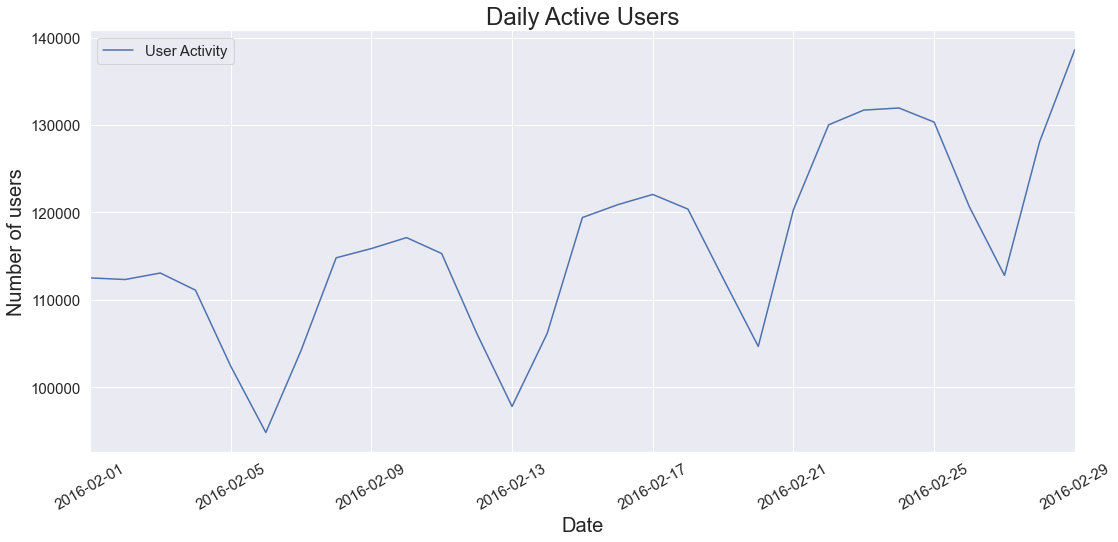

In [412]:
daily_users = df.groupby('date')['uid'].nunique()
x_values = daily_users.index
y_values = daily_users.values
xmin,xmax = x_values[0],x_values[-1]

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(x_values,y_values)

ax.set_title('Daily Active Users',fontsize=24)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Number of users',fontsize=20)
ax.set_xlim(xmin = xmin, xmax = xmax)
ax.legend(['User Activity'],fontsize=15,loc='upper left')

plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

### Key points:
* The number of active users over the month of February seem to be going up as the month progresses.
* There is a sharp dip in the daily activity of the users every 7 days or so indicating the decline over the weekends.

## 2. Daily retention curve

We need to first calculate the ids of people who joined the platform on the dates of Feb 4th, Feb 10th ,and Feb 14th. 

In [388]:
def get_new_users(date):  
    """
    Input the date in YYYY-MM-DD format and the function outputs an array of new users who joined
    the platform on that particular day.
    """
    
    date = pd.to_datetime(date)
    ids = df[(df['date']== date) & (df['isFirst']==True)]['uid'].values
    return ids

In [389]:
print(f"The number of unique users in each cohort:\
      \nFeb 04: {len(get_new_users('2016-02-04'))},\
      \nFeb 10: {len(get_new_users('2016-02-10'))},\
      \nFeb 14: {len(get_new_users('2016-02-14'))}.")             

The number of unique users in each cohort:      
Feb 04: 2735,      
Feb 10: 3135,      
Feb 14: 2761.


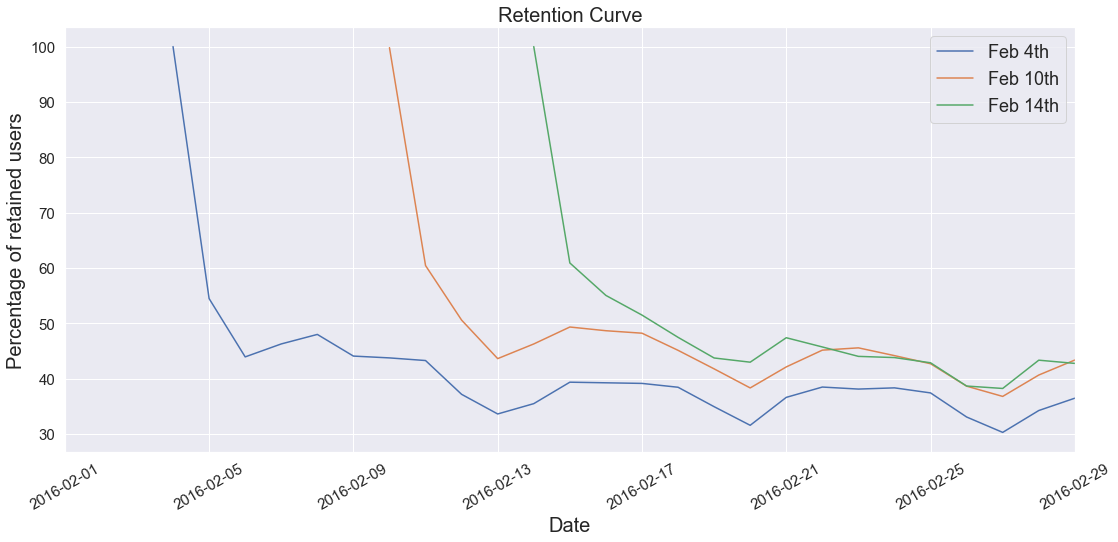

In [396]:
fig,ax = plt.subplots(figsize=(16,8))

for date in ('2016-02-04','2016-02-10','2016-02-14'):
    retention_users = (df[df['uid'].isin(get_new_users(date))].groupby('date')['uid'].nunique()*100.0/len(get_new_users(date)))
    x_values = retention_users.index
    y_values = retention_users.values
    ax.plot(x_values,y_values)
    
ax.set_title('Retention Curve',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Percentage of retained users',fontsize=20)
ax.set_xlim(xmin = xmin,xmax=xmax)
ax.legend(['Feb 4th', 'Feb 10th', 'Feb 14th'],fontsize=18,loc='upper right')
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

### Key points:
* The retention curves for all three dates indicate that the retention rate plateaus around the 40-50 % mark within a week.
* The retnetion curves on Feb 10th and Feb 14th are doing better(~ 45%) than the retention curve from Feb 4th(~ 35%).
* It is possible that some major changes took place as far as the platform is concerned and maybe, that's what causing the higher retention rate.
* The same periodicity can be observed here just like we observed in the case of Daily active users owing to the weekend factor.

## 3(a). Differences in usage based on the source.

In [133]:
sources = df['utmSource'].unique()
num_sources = df['utmSource'].nunique()

In [397]:
print(f'There are {num_sources} unique sources listed for the platform.' )

There are 52 unique sources listed for the platform.


In [132]:
sources

array(['Biznesowe+Rewolucje', 'program', None, 'answers', 'shmoop_left',
       'twitter', 'dict', 'other', 'MosaLingua+FR', 'facebook',
       'salesmanago', 'MembershipCancellation', 'placement', 'handbook',
       'Grub+Street', 'youtube', 'Just-In-Time+Travels+Newsletter',
       'Facebook_org', 'tapjoy', 'Book+Quote', 'contenthub', 'liveintent',
       'blog', 'Blog_org', 'bing', 'LinkedIn_org', 'google',
       'Wise+Ink+Master+Email+List', 'Bing', 'Twitter_org', 're:+charity',
       'nettedbythewebbys', "Sarah+Doody's+UX+Notebook", 'Pre-quote+List',
       'facebook.com', 'email-sendgrid', 'sendgrid.com', 'shmoop_logo',
       'SummerInvite', 'TrialIntro', 'digg', 'outbrain', 'brand',
       'cafemom.com', 'GPlus_org', 'shmoop_right', 'gsp',
       'Sticky Blogging Secrets', 'pandora', 'taboola',
       'blogger_outreach', 'display', 'card'], dtype=object)

One of them happens to be **None**. Looks like there are quite a few entries with no sources attributed to them. Let's see!

In [398]:
df['utmSource'].isna().sum()   # 1.6 million entries with no info on the source

1674386

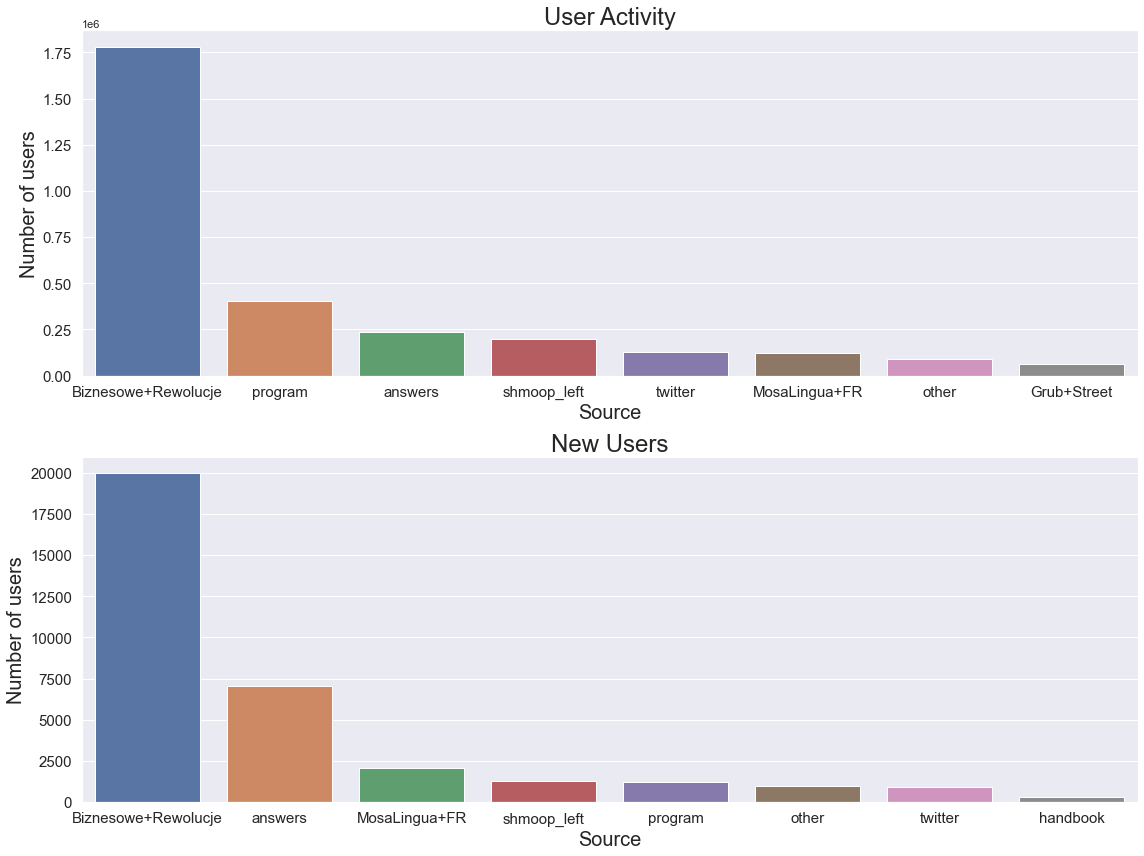

In [482]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(16,12))

sns.countplot(df['utmSource'],order=df.utmSource.value_counts().iloc[:8].index,ax=ax1)
ax1.set_title('User Activity',fontsize=24)
ax1.set_xlabel('Source',fontsize=20)
ax1.set_ylabel('Number of users',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)

new_users = df.groupby('utmSource')['isFirst'].sum().sort_values(ascending=False)[:8]
sns.barplot(new_users.index,new_users.values,ax=ax2)
ax2.set_title('New Users',fontsize=24)
ax2.set_xlabel('Source',fontsize=20)
ax2.set_ylabel('Number of users',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

In [498]:
total_new_users = df.groupby('utmSource')['isFirst'].sum().sum()
for source,val in new_users.iteritems():
    print(f'The percentage of new users for {source:>20}:{val*100.0/total_new_users :>10.3f} %')

The percentage of new users for  Biznesowe+Rewolucje:    58.227 %
The percentage of new users for              answers:    20.634 %
The percentage of new users for        MosaLingua+FR:     6.041 %
The percentage of new users for          shmoop_left:     3.696 %
The percentage of new users for              program:     3.556 %
The percentage of new users for                other:     2.894 %
The percentage of new users for              twitter:     2.704 %
The percentage of new users for             handbook:     0.825 %


### Remark: 
From these two graphs, it is easy to see that most of the traffic is coming in from a handful of sources, i.e. Biznesowe+Rewolucje, answers, program, shmoop_left, and so on. This can be seen from the graph on the top which shows the total activity over the month for each of the sources and also from the second graph which shows the number of new users who joined the platform from these particular sources. 
* The number of new users joining the platform are primarily coming from two major sources: Biznesowe+Rewolucje and answers with 58% and 20%, respectively.

In [411]:
def user_activity_curve(source):
    '''
    This function takes in the source as input and outputs a pandas series of the user activity specific to the ones
    who identified themselves with the source.
    '''
    ids = df[(df['utmSource']==source)&(df['isFirst']==True)]['uid'].values
    users = len(ids)
    return df[df['uid'].isin(ids)].groupby('date')['uid'].nunique()   

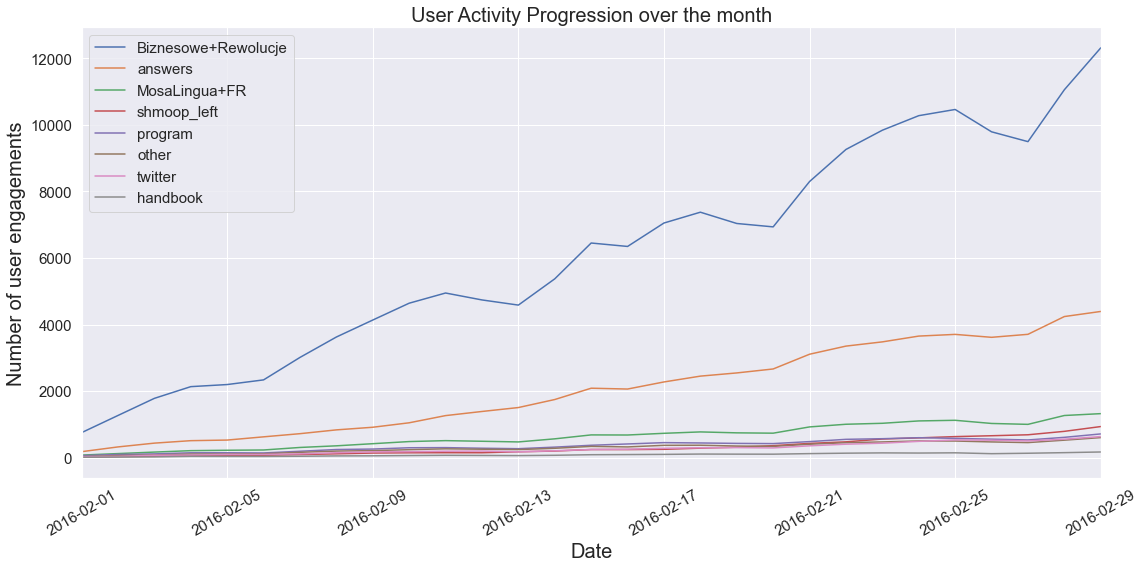

In [511]:
fig, ax = plt.subplots(figsize=(16,8))
sources = new_users.index
for source in sources:
    user_activity = user_activity_curve(source)
    x_values = user_activity.index
    y_values = user_activity.values
    ax.plot(x_values,y_values,label=source)
    
ax.set_title('User Activity Progression over the month',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Number of user engagements',fontsize=20)
ax.set_xlim(xmin = xmin, xmax = xmax)
ax.legend(fontsize=15,loc='upper left')
plt.xticks(rotation=30,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

### Remark(contd..):
The plot of 'User Activity Progression' shows that as the month progresses, the number of user engagements increase partly due to the activity of the existing users as well as the users who joined in over the month. Again, most of the  traffic can be attributed to two sources: Biznesowe+Rewolucje and answers.

## 3(b). Best/Worst users

In order for us to work with the best/worst users, let's first drop the rows for which we have no information about the sources.

In [502]:
df_new = df.dropna()

In [572]:
df_new.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,2016-02-29 08:00:01.255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,2016-02-29 08:00:01.556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,2016-02-29 08:00:01.770,75121338,False,program
5,2016-02-29,2016-02-29 08:00:03.620,53677597,False,Biznesowe+Rewolucje
6,2016-02-29,2016-02-29 08:00:03.694,53171302,False,program


Each unique user id must come from the same source every time he/she logs in. Let's confirm this before moving on.

In [573]:
unique_users = df_new['uid'].nunique()
unique_user_source = df_new.groupby('uid')['utmSource'].nunique().count()
assert (unique_users == unique_user_source)
print(f'The number of unique users: {unique_users}.')
    

The number of unique users: 147737.


This assertion confirms that any unique user_id will come from only one single source.

In [621]:
user_group = df_new.groupby(['uid','date'])['timestamp'].count()
user_group = pd.DataFrame(user_group).reset_index([0,1])
user_group.columns = ['uid','date','Interactions']

In [622]:
mean_engagements = user_group.groupby('uid')['Interactions'].mean().rename('Mean interactions per day')
daily_engagements = user_group.groupby('uid')['Interactions'].count().rename('Days of interaction')
source_engagements = pd.Series(df_new.groupby('uid')['utmSource'].unique(),name = 'source_engagements').apply(lambda x: x[0])

In [ ]:
user_group = pd.merge(user_group,mean_engagements,left_on='uid',right_index=True)
user_group = pd.merge(user_group,daily_engagements,left_on='uid',right_index=True)
user_group = pd.merge(user_group,source_engagements,left_on='uid',right_index=True)
user_group = user_group.drop('Interactions',axis=1)

In [710]:
user_group.head()

,uid,date,Mean interactions per day,Days of interaction,source_engagements
0,008wXBXcFOF5,2016-02-01,4.0,1,Biznesowe+Rewolucje
1,00X99FtrcUOu,2016-02-01,1.0,4,Biznesowe+Rewolucje
2,00X99FtrcUOu,2016-02-02,1.0,4,Biznesowe+Rewolucje
3,00X99FtrcUOu,2016-02-11,1.0,4,Biznesowe+Rewolucje
4,00X99FtrcUOu,2016-02-18,1.0,4,Biznesowe+Rewolucje


The dataframe **user_group** refers to the engagements of every unique user. The columns 'Mean interaction per day', 'Days of interaction' and 'source_engagements' correspond to the mean interactions per day, number of days of interaction, and the source of interaction, respectively.

**Best/Worst User Criteria:** The criteria to choosing the best/worst or good/bad user can be subjective to the threshold of our choice. For example, we can consider a user who engages for at least 20 days and at least 5 times a day as the best user. On the other hand, a user who barely logs on for even 10 days for maybe, once or twice can be construed as the worst user. We can relax those conditions a bit and we have a broader good/bad category. The threshold I have chosen for this study can be seen in the following cell.

In [685]:
best_user_condition = (user_group['Mean interactions per day']>=5) & (user_group['Days of interaction']>=20)
good_user_condition = (user_group['Mean interactions per day']>=5) | (user_group['Days of interaction']>=20)
bad_user_condition = (user_group['Mean interactions per day']<2) | (user_group['Days of interaction']<10)
worst_user_condition = (user_group['Mean interactions per day']<2) & (user_group['Days of interaction']<10)

In [677]:
print(f" Best users:{user_group[best_user_condition]['uid'].nunique():>10}.")
print(f" Good users:{user_group[good_user_condition]['uid'].nunique():>10}.")
print(f"  Bad users:{user_group[bad_user_condition]['uid'].nunique():>10}.")
print(f"Worst users:{user_group[worst_user_condition]['uid'].nunique():>10}.")

 Best users:       347.
 Good users:     58604.
  Bad users:    137719.
Worst users:     32642.


In [705]:
num_best_users = user_group[best_user_condition].groupby('source_engagements').size().sum()
num_worst_users = user_group[worst_user_condition].groupby('source_engagements').size().sum()

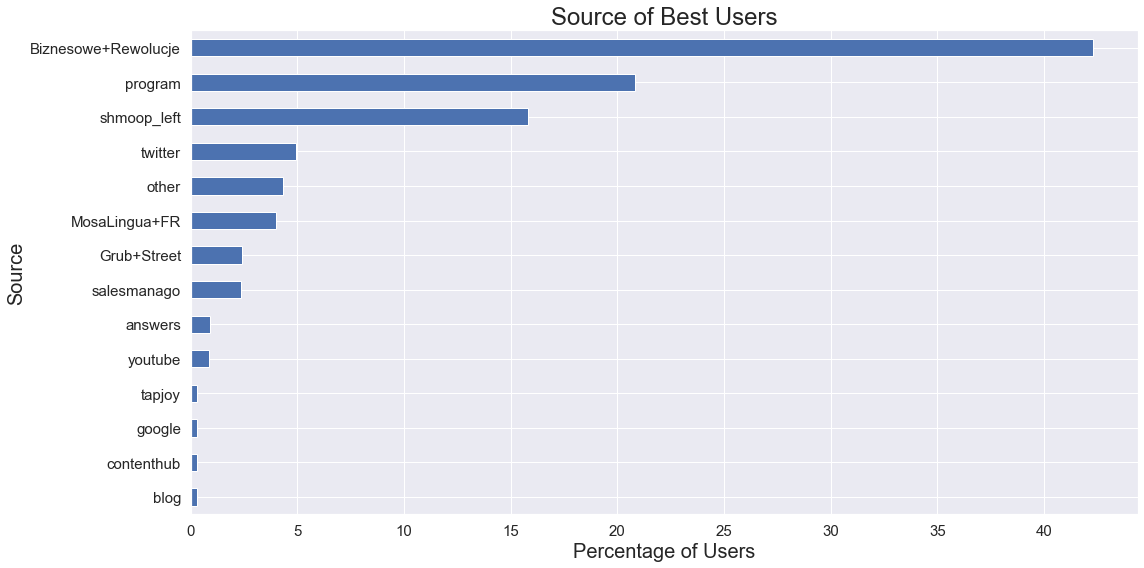

In [709]:
fig, ax = plt.subplots(figsize=(16,8))

ax = (user_group[best_user_condition].groupby('source_engagements').size().sort_values()*100.0/num_best_users).plot(kind='barh')
ax.set_title('Source of Best Users',fontsize=24)
ax.set_xlabel('Percentage of Users',fontsize=20)
ax.set_ylabel('Source',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

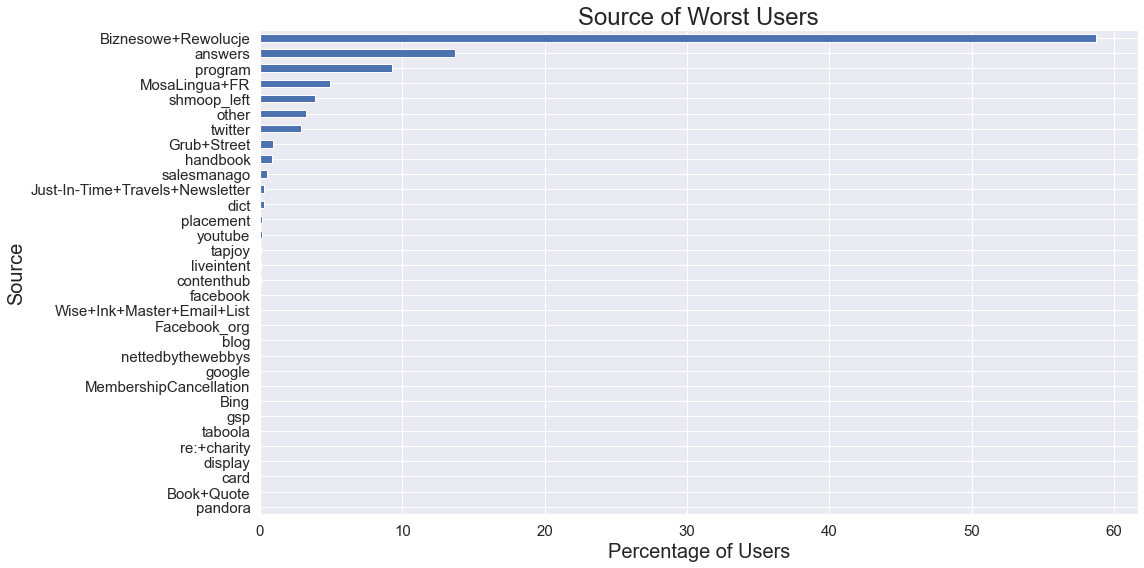

In [708]:
fig, ax = plt.subplots(figsize=(16,8))

ax = (user_group[worst_user_condition].groupby('source_engagements').size().sort_values()*100.0/num_worst_users).plot(kind='barh')
ax.set_title('Source of Worst Users',fontsize=24)
ax.set_xlabel('Percentage of Users',fontsize=20)
ax.set_ylabel('Source',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

### Key points:
* Biznesowe+Rewolucje leads as the source of both, best as well as worst users. Almost 45% of the best users come from Biznesowe+Rewolucje. However, it also accounts for almost 60% of its worst users.
* Programs, on the other hand, accounts for about 20% of the best users while only accounting for around 10% of the worst users. In relative terms, programs seems to be doing much better than Biznesowe+Rewolucje.
* Another important contributor towards the best users is shmoop_left with a share of almost 16% of the best users. It also has a very tiny percentage of its share among the worst users(~ 5%).
* Overall, although Biznesowe+Rewolucje accounts for almost half of the traffic for the platform, I'd still work towards getting the numbers up for the competing sources that have relatively impressive numbers in addition to making changes and improving this source which brings in almost half the traffic.

## Amol Ratnaparkhe
Date: 06-01-2021.